In [1]:
import os, os.path
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

## 1. Analysis of the image files
### 1.1 Showing a few sample images

c:\Users\Habram\Anaconda3\envs\nlp\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


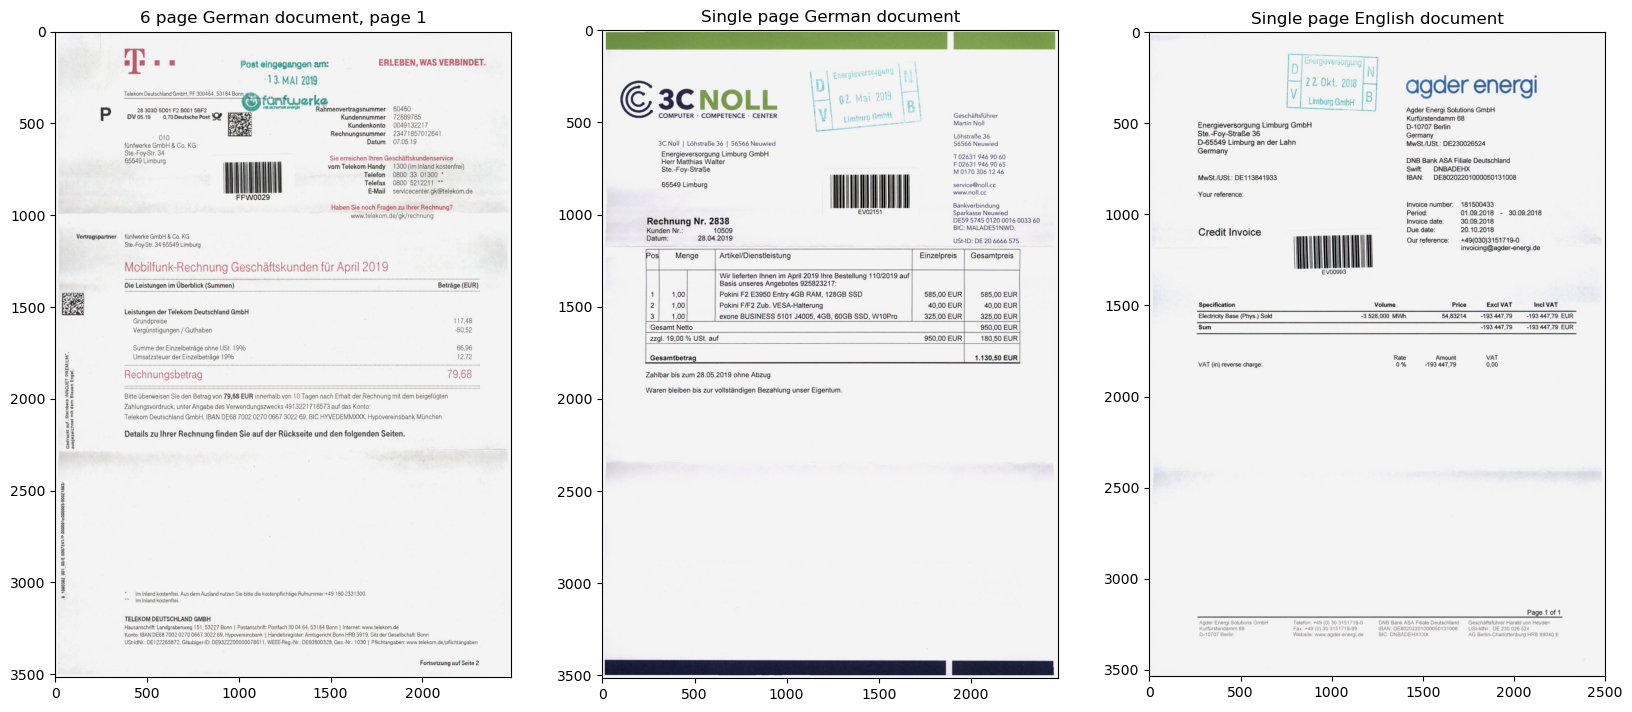

In [2]:
path_de = r'C:\Users\Habram\Documents\Datasets\SER\Invoice_de'
path_en = r'C:\Users\Habram\Documents\Datasets\SER\Invoice_en'

example_image1 = Image.open(path_de + '\\(Mobilf.)TelekomDeutschl.GmbH_T005.tif')
example_image2 = Image.open(path_de + '\\3c-NollComputerCompetence_C086_2.tif')
example_image3 = Image.open(path_en + '\\AgderEnergiSolutionsGmbH_A178_3.tif')

fig, axs = plt.subplots(1,3)
fig.set_figheight(20)
fig.set_figwidth(20)
axs[0].imshow(example_image1)
axs[1].imshow(example_image2)
axs[2].imshow(example_image3)
axs[0].set_title('6 page German document, page 1')
axs[1].set_title('Single page German document')
axs[2].set_title('Single page English document')
plt.show()

### 1.2 Size comparison: German vs English images

In [3]:
count_de = 0
for root_dir, cur_dir, files in os.walk(path_de):
    count_de += len(files)

count_en = 0
for root_dir, cur_dir, files in os.walk(path_en):
    count_en += len(files)

count_de //= 2
count_en //= 2

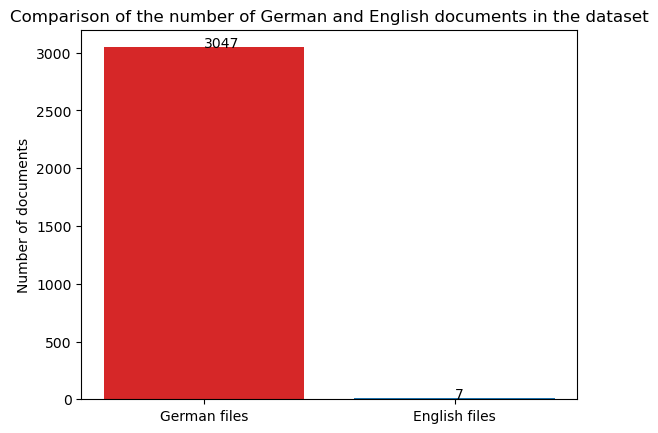

In [4]:
fig, ax = plt.subplots()

labels = ['German files', 'English files']
counts = [count_de, count_en]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(labels, counts, color=bar_colors)

ax.set_ylabel('Number of documents')
ax.set_title('Comparison of the number of German and English documents in the dataset')

for i in range(len(labels)):
    plt.text(i,counts[i],counts[i])

plt.show()

### 1.3 How many pages do the images have

In [5]:
import collections

page_dist = dict()

for filename in os.listdir(path_de):
    if filename.endswith(".tif"):
        img = Image.open(path_de + "\\" + filename)
        if img.n_frames not in page_dist.keys():
            page_dist[img.n_frames] = 1
        else:
            page_dist[img.n_frames] += 1

# Order the dictionary based on keys
page_dist = collections.OrderedDict(sorted(page_dist.items()))

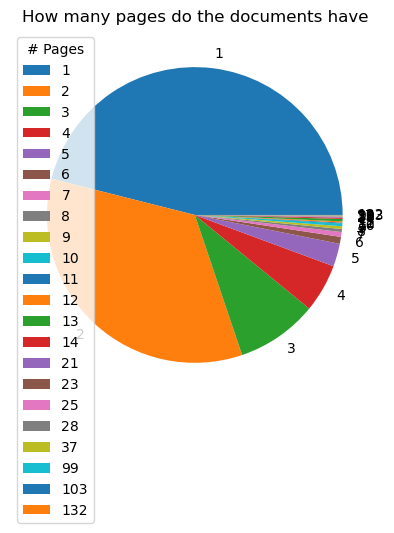

In [6]:
sizes = page_dist.values()
labels = page_dist.keys()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
ax.set_title('How many pages do the documents have')
ax.legend(title='# Pages', loc='best')
plt.show()

## 2. Analysis of the labels

The high-level structure of a raw file which involves the labels:
- cdoc
    - pages
    - sourcefiles
- ClsResults
- representations
    - representation
    - representation
    - representation
- fields
- locators
- valrules
- xvalues

The properties of the elements are detailed below.

In [7]:
import xml.etree.ElementTree as ET

tree = ET.parse(path_en + '\\AgderEnergiSolutionsGmbH_A178_3')
root = tree.getroot()

### 2.1 cdoc
- pages: every page has an element, page width, height resolution are stored here
- sourcefiles: corresponding image file name is stored here

In [8]:
for child in root[0]:
    print(child[0].attrib)

{'xres': '300', 'yres': '300', 'sfindex': '0', 'height': '3537', 'width': '2502', 'ind-sf': '0', 'rotation': '0', 'splitpage': '0', 'ExecOCR': '0', 'guid': 'ea0dfb29-e7c2-4a9b-ac65-d01a14e76c79', 'licnpayed': '208:1;210:1;525:1'}
{'fname': 'AgderEnergiSolutionsGmbH_A178_3.tif', 'ftype': 'TIFF', 'findex': '0', 'pagecount': '1', 'ind-doc': '0', 'mtime': '1540209395', 'relpath': ''}


### 2.2 ClsResults 
This element does not have any further sub-elements

### 2.3 representations
#### 2.3.1 representation #1
- pages: how many page does the document have. How many words, lines, blocks are located on each page.
- textlines: coordinates of the lines, which words are in that line
- boxes: 
- blocks: coordinates of the blocks, which words are in the block. (A block can be considered as a semantic block, where even more words are grouped together. Ex: address consists of street + house number.)
- words: coordinates of the bounding boxes of the woords

In [9]:
def coords_extraction(source):
    coords_array = []

    for child in source:
        coords_array.append([int(child.attrib['left']), int(child.attrib['top']), int(child.attrib['left'])+int(child.attrib['width']), int(child.attrib['top'])+int(child.attrib['height'])])

    return coords_array

coords_textlines = coords_extraction(root[2][0][4])
coords_blocks = coords_extraction(root[2][0][7])
coords_words = coords_extraction(root[2][0][8])

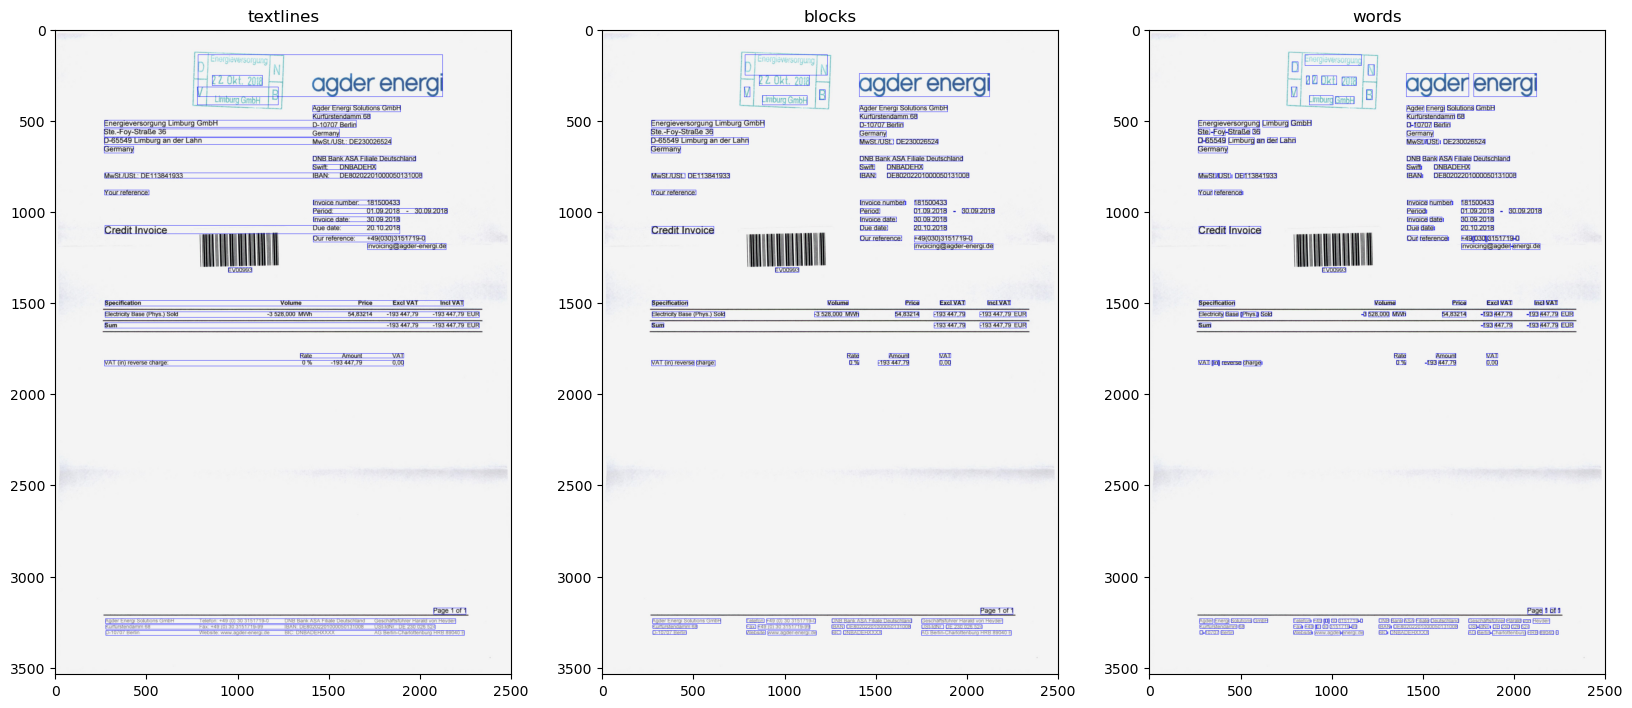

In [10]:
textline_image = Image.open(path_en + '\\AgderEnergiSolutionsGmbH_A178_3.tif')
block_image = Image.open(path_en + '\\AgderEnergiSolutionsGmbH_A178_3.tif')
word_image = Image.open(path_en + '\\AgderEnergiSolutionsGmbH_A178_3.tif')

fig, axs = plt.subplots(1,3)
fig.set_figheight(20)
fig.set_figwidth(20)

# Draw the texlines
draw = ImageDraw.Draw(textline_image, "RGBA")
font = ImageFont.load_default()
for box in coords_textlines:
    draw.rectangle(box, outline='blue', width=2)
axs[0].imshow(textline_image)

# Draw the blocks
draw = ImageDraw.Draw(block_image, "RGBA")
font = ImageFont.load_default()
for box in coords_blocks:
    draw.rectangle(box, outline='blue', width=2)
axs[1].imshow(block_image)

# Draw the words
draw = ImageDraw.Draw(word_image, "RGBA")
font = ImageFont.load_default()
for box in coords_words:
    draw.rectangle(box, outline='blue', width=2)
axs[2].imshow(word_image)


axs[0].set_title('textlines')
axs[1].set_title('blocks')
axs[2].set_title('words')
plt.show()

#### 2.3.2 representation #2
- pages: how many page does the document have. How many lines located on each page.
- lines: line representation differently

#### 2.3.3 representation #3
- pages: how many page does the document have. How many lines located on each page.
- lines: line representation differently

### 2.4 fields

In [11]:
labels = []

for child in root[3]:
    if child.attrib.get('name') == None:
        continue
    if child[0].text == None:
        continue
    if int(child.attrib.get('left')) == -1:
        continue
    left = int(child.attrib.get('left'))
    top = int(child.attrib.get('top'))
    right = int(child.attrib.get('left')) + int(child.attrib.get('width'))
    bottom = int(child.attrib.get('top')) + int(child.attrib.get('height'))
    labels.append(
        {
            'coords': [left, top, right, bottom],
            'label' : child.attrib.get('name'),
            'text'  : child[0].text
        }
    )

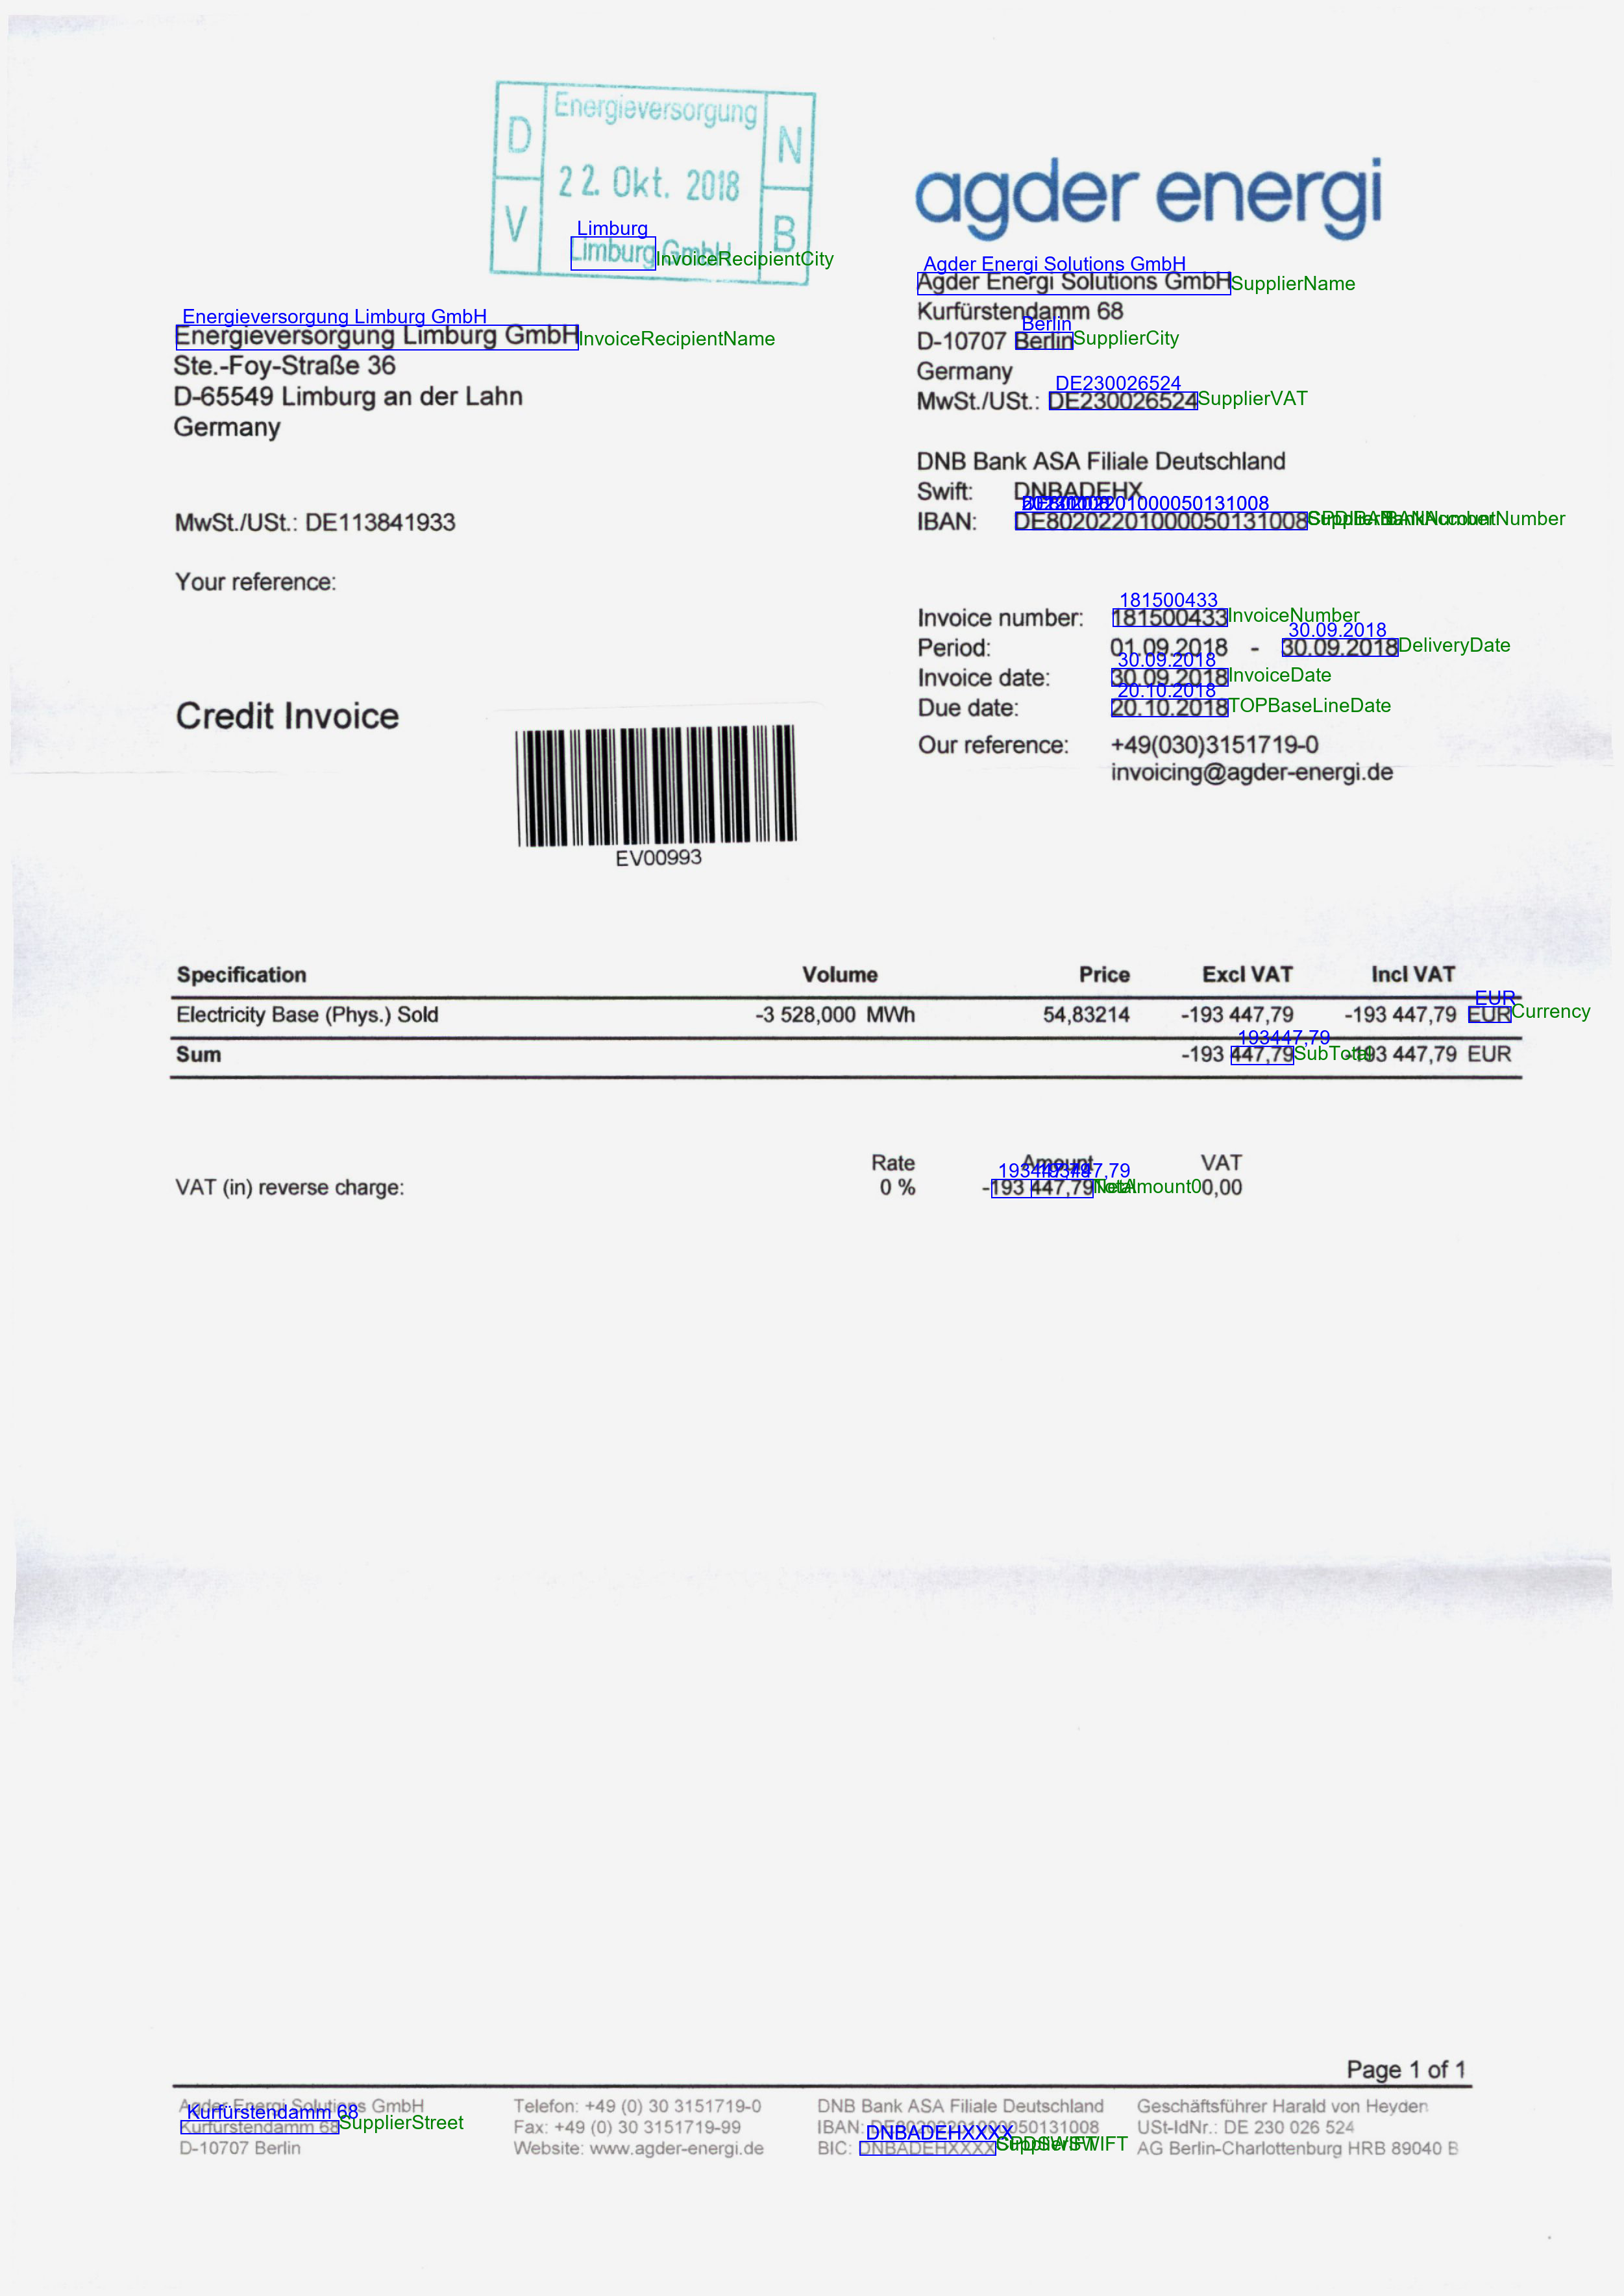

In [12]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(path_en + '\\AgderEnergiSolutionsGmbH_A178_3.tif')

draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.truetype("arial.ttf", 30)

for label in labels:
    draw.rectangle(label['coords'], outline='blue', width=2)
    draw.text((label['coords'][0] + 10, label['coords'][1] - 30), label['text'], fill='blue', font=font)
    draw.text((label['coords'][2], label['coords'][3] - 35), label['label'], fill='green', font=font)

image

### 2.4.1. More data analysis on the fields attribute
There are many labels which have corresponding texts, but do not have coordinates. Since the coordinates of the words are known, the coordinates of the labels can be found.
Task: find the missing label coordinates based on the words. There are 2 cases:
- The label covers a single word
- The label covers multiple words

In [13]:
# Build a list of dictionaries which describes the word - bounding box - wordID relations
# It can be used to find the bounding box of a given word directly
words2boxes = []

for child in root[2][0][8]:
    left = int(child.attrib['left'])
    top = int(child.attrib['top'])
    right = int(child.attrib['left'])+int(child.attrib['width'])
    bottom = int(child.attrib['top'])+int(child.attrib['height'])
    words2boxes.append(
        {
            'word' : child[0].text,
            'coords': [left, top, right, bottom],
            'wordID' : child.attrib['ind-doc']
        }
    )
    

In [48]:
# Build a list of dictionaries which describes which words belong to which block
# It can be used when a label includes multiple words and their bounding box is needed
blocks2boxes = []

for child in root[2][0][7]:
    left = int(child.attrib['left'])
    top = int(child.attrib['top'])
    right = int(child.attrib['left'])+int(child.attrib['width'])
    bottom = int(child.attrib['top'])+int(child.attrib['height'])
    
    # Get the list of word IDs
    wordIDs = child.attrib['words'].split(";")[:-1]  # Split the string at each semicolon and remove the last empty element
    wordIDs = [int(num) for num in wordIDs]

    # Replace the wordIDs with textual words
    words_text = []
    for target_wordID in wordIDs: # iterate through the wordIDs
        for word in words2boxes:  # find the related textual word to the ID
            if int(word['wordID']) == target_wordID:
                words_text.append(word['word'])

    blocks2boxes.append(
        {
            'coords': [left, top, right, bottom],
            'words' : words_text
        }
    )

In [15]:
# Build a list of dictionaries which describes the fields attribute of the XML file: coordinates - labels - text
# It can be used to visualize the annotations
fields = []

for child in root[3][1:]:
    left = int(child.attrib['left'])
    top = int(child.attrib['top'])
    right = int(child.attrib['left'])+int(child.attrib['width'])
    bottom = int(child.attrib['top'])+int(child.attrib['height'])
    fields.append(
        {
            'coords': [left, top, right, bottom],
            'label' : child.attrib.get('name'),
            'text'  : child[0].text
        }
    )

In [26]:
# How many labels have corresponding coordinates?
i = 0
for entity in fields:
    if entity['coords'] != [-1, -1, -2, -2] and entity['text'] != None:
        i += 1
print('Number of labels which have coordinates too: ', i)

# How many labels do not have corresponding coordinates, but have text
i = 0
for entity in fields:
    if entity['coords'] == [-1, -1, -2, -2] and entity['text'] != None:
        i += 1
print('Number of labels which do not have corresponding coordinates, but have text: ', i)

# How 
print('Number of labels in total: ', len(fields))


Number of labels which have coordinates too:  20
Number of labels which do not have corresponding coordinates, but have text:  41
Number of labels in total:  76


In [ ]:
# Update the labels which do not have coordinates
# Labels to be updated
fileds_updated = []

for entity in fields:
    if entity['coords'] == [-1, -1, -2, -2] and entity['text'] != None:
        fileds_updated.append(entity)

for entity in fileds_updated:
    text = entity['text'].split()
    
    for item in blocks2boxes:
        print(text, '******************',  item['words'])
        if text == item['words']:
            print(text)

# NO MATCH HAS BEEN FOUND!!!

In [68]:
# Let's repeat it with single words
fileds_updated = []

for entity in fields:
    if entity['coords'] == [-1, -1, -2, -2] and entity['text'] != None:
        fileds_updated.append(entity)

for entity in fileds_updated:
    text = entity['text'].split()
    
    for item in words2boxes:
        #print(type(str(text[0])), '******************',  type(item['word']))
        if str(text[0]) == item['word']:
            print(text)

['Agder', 'Energi', 'Solutions', 'GmbH_A178']
['Agder', 'Energi', 'Solutions', 'GmbH_A178']
['10707']
['10707']
['DE']
['DE']
['0']
['0']
['0']
['DE']
['DE']
['65549']
['0']
['0']
['0']
['0']
['0']
['0']
['0']
['0']
['0']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']
['0,00']


### 2.5 locators
It seems garbage

### 2.6 valrules
A few labels are enumerated, without any additional information

In [71]:
for child in root[5]:
    print(child.attrib)

{'name': 'RuleCurrency', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RulePostingDate', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleNettoTaxRateTax1', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleNettoTaxRateTax2', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleNettoTaxRateTax3', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleNettoTaxRateTax4', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleInvoiceValidation', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleSupplierId', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleDisqualifyAnnotation', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RulePosting', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleTOPDiscountTo1', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleTOPDiscountTo2', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleTOPDiscountTo3', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleNetAmountsBugWorkaround', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleTOPCashDiscount', 'InpChng': '0', 'RuleVal': '1'}
{'name': 'RuleInvoiceNumber', 'InpChng': '0', 'R

### 2.7 xvalues

In [76]:
xvalues = dict()

for child in root[6]:
    xvalues[child.attrib['key']] = child.attrib['value']

In [77]:
xvalues

{'AC_CSS_Kofax.Transformation.Reports.ClassificationConfidence': '0',
 'AC_CSS_Kofax.Transformation.Reports.ClassificationIsConfident': '1',
 'AC_CSS_de.ser.ae.ac.workflow.dicwal.release.module': '+AF8AXw-EMPTY+AF8AXw-',
 'AC_CSS_de.ser.ae.ac.workflow.dicwal.release.note': '+AF8AXw-EMPTY+AF8AXw-',
 'AC_CSS_de.ser.ae.ac.workflow.dicwal.release.resubmit': 'false',
 'AC_CSS_de.ser.ae.ac.workflow.dicwal.release.state': '+AF8AXw-EMPTY+AF8AXw-',
 'AC_CSS_de.ser.ae.read.im.datetime.server': '22.10.2018 13:59:46',
 'AC_CSS_de.ser.ae.read.im.datetime.validation': '22.10.2018 14:17:45',
 'AC_CSS_de.ser.ae.read.im.hostname.server': 'SER-DIMR',
 'AC_CSS_de.ser.ae.read.im.hostname.validation': 'B-COM-DT18-00',
 'AC_CSS_de.ser.ae.read.im.username.server': 'ser-admin',
 'AC_CSS_de.ser.ae.read.im.username.validation': 'Etheber',
 'AC_CSS_de.ser.ae.read.properties.amounts.timeout': '0',
 'AC_CSS_de.ser.ae.read.properties.invoicerecipient_db': 'RHENAGRZ||1||EL0||Energieversorgung Limburg GmbH||Ste-Foy-S